# ML Code Critic with ASTs on Kaggle

This notebook trains a machine learning model to critique Python code quality based on its Abstract Syntax Tree (AST). The process includes:
1.  **Configuration**: Setting up file paths and parameters.
2.  **Feature Extraction**: Defining a class to handle all logic.
3.  **Data Loading**: Loading the Py150 dataset from the Kaggle environment.
4.  **Model Training**: Training RandomForest models with hyperparameter tuning.
5.  **Inference**: Using the trained model to critique new code samples.

In [21]:
# import tarfile

# archive_path = '/kaggle/input/150k-python-dataset/py150.tar_1'
# output_dir = '/kaggle/working/py150'

# with tarfile.open(archive_path) as tar:
#     tar.extractall(output_dir)

# print("Extracted files to:", output_dir)

### Cell 1: Imports

In [22]:
import json
import numpy as np
from collections import defaultdict
import pickle
import os

import matplotlib.pyplot as plt
from scipy.stats import randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Cell 2: Configuration
We define all constants here for easy management. This includes file paths, model names, and training parameters.

In [23]:
# Directory where Kaggle datasets are typically located after unzipping
DATA_DIR = "/kaggle/working/py150/"

# Filenames for the dataset
# Note: The actual dataset from Kaggle has '.jsonl' extension
TRAIN_FILENAME = "python100k_train.json"
EVAL_FILENAME = "python50k_eval.json"

# Filepath for the saved model in the output directory
MODEL_FILENAME = "optimized_py150_model.pkl"
MODEL_PATH = f"/kaggle/working/{MODEL_FILENAME}"

# Training parameters
MAX_SAMPLES = 100000 # Use a smaller number for faster runs
RANDOM_STATE = 42

### Cell 3: The `MLCodeCriticAST` Class
This class contains all the logic for feature extraction, training, and prediction. It has been simplified for clarity.

In [24]:
class MLCodeCriticAST:
    def __init__(self):
        self.quality_classifier = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
        self.naming_classifier = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
        self.style_classifier = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
        self.scaler = StandardScaler()
        self.is_trained = False

    def extract_features_from_ast(self, ast_json):
        node_counts = defaultdict(int)
        names = []
        for node in ast_json:
            if isinstance(node, dict) and 'type' in node:
                node_type = node['type']
                node_counts[node_type] += 1
                if 'value' in node and isinstance(node['value'], str):
                    names.append(node['value'])
        
        # Naming and style features
        name_len = np.mean([len(n) for n in names]) if names else 0
        snake_case = sum(1 for n in names if '_' in n and n.islower())
        camel_case = sum(1 for n in names if n != n.lower() and '_' not in n)
        
        # Complexity and structure features
        complexity = node_counts['If'] + node_counts['For'] + node_counts['While']

        features = np.array([
            node_counts['FunctionDef'], node_counts['ClassDef'], node_counts['Assign'],
            node_counts['Import'] + node_counts['ImportFrom'], complexity,
            node_counts['NameStore'], node_counts['NameLoad'], len(names), len(ast_json),
            node_counts['Call'], node_counts['attr'], node_counts['Str'], node_counts['Return'],
            node_counts['arguments'], node_counts['body'],
            name_len, snake_case, camel_case, 0, 0 # Padding for consistent feature count
        ], dtype=float)
        return features

    def load_py150_jsonl(self, filepath, max_samples):
        data = []
        print(f"Loading up to {max_samples} samples from {filepath}...")
        if not os.path.exists(filepath):
            print(f"Error: File not found at {filepath}")
            return []

        with open(filepath, 'r') as f:
            for i, line in enumerate(f):
                if i >= max_samples: break
                try:
                    ast_json = json.loads(line)
                    features = self.extract_features_from_ast(ast_json)
                    # Heuristic-based labeling for training
                    quality = 60 + 10 * (features[0] > 0) + 10 * (features[1] > 0) - 10 * (features[4] > 10)
                    naming = 60 + 10 * (features[15] > 6) - 10 * (features[16] < 2)
                    style = 60 + 10 * (features[3] > 0) - 10 * (features[12] > 5)
                    data.append({
                        "features": features,
                        "quality_score": min(100, max(0, quality)),
                        "naming_score": min(100, max(0, naming)),
                        "style_score": min(100, max(0, style))
                    })
                except json.JSONDecodeError:
                    continue
        print(f"Successfully loaded {len(data)} samples.")
        return data

    def train_models(self, train_data):
        print("\n=== Starting Model Training ===")
        X = np.array([d["features"] for d in train_data])
        y_quality = np.array([self._score_to_category(d["quality_score"]) for d in train_data])
        y_naming = np.array([self._score_to_category(d["naming_score"]) for d in train_data])
        y_style = np.array([self._score_to_category(d["style_score"]) for d in train_data])
        
        # Split data once for all models
        X_train, X_test, yq_train, yq_test, yn_train, yn_test, ys_train, ys_test = train_test_split(
            X, y_quality, y_naming, y_style, test_size=0.2, random_state=RANDOM_STATE, stratify=y_quality
        )

        self.scaler.fit(X_train)
        X_train_scaled = self.scaler.transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Tune, train, and evaluate each model
        self.quality_classifier = self._tune_and_train(X_train_scaled, yq_train, 'Quality')
        self._evaluate_and_plot(X_test_scaled, yq_test, self.quality_classifier, 'Quality')

        self.naming_classifier = self._tune_and_train(X_train_scaled, yn_train, 'Naming')
        self._evaluate_and_plot(X_test_scaled, yn_test, self.naming_classifier, 'Naming')

        self.style_classifier = self._tune_and_train(X_train_scaled, ys_train, 'Style')
        self._evaluate_and_plot(X_test_scaled, ys_test, self.style_classifier, 'Style')

        self.is_trained = True
        print("\n=== Training Complete ===")

    def _tune_and_train(self, X_train, y_train, model_name):
        print(f"\n--- Tuning {model_name} Model ---")
        param_dist = {
            'n_estimators': randint(50, 200), 'max_depth': randint(5, 20),
            'min_samples_split': randint(2, 11), 'min_samples_leaf': randint(1, 5)
        }
        rand_search = RandomizedSearchCV(
            RandomForestClassifier(random_state=RANDOM_STATE), param_distributions=param_dist, 
            n_iter=15, cv=3, scoring='f1_macro', random_state=RANDOM_STATE, n_jobs=-1
        )
        rand_search.fit(X_train, y_train)
        print(f"Best Score: {rand_search.best_score_:.3f}")
        return rand_search.best_estimator_
        
    def _evaluate_and_plot(self, X_test, y_test, model, model_name):
        print(f"\n--- Evaluating {model_name} Model ---")
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)
        plt.title(f'{model_name} Model Confusion Matrix')
        plt.show()

    def predict(self, ast_json):
        if not self.is_trained: return {"error": "Model not trained."}
        features = self.extract_features_from_ast(ast_json).reshape(1, -1)
        X_scaled = self.scaler.transform(features)

        quality_pred = self.quality_classifier.predict(X_scaled)[0]
        naming_pred = self.naming_classifier.predict(X_scaled)[0]
        style_pred = self.style_classifier.predict(X_scaled)[0]
        
        return {
            'quality': quality_pred,
            'naming': naming_pred,
            'style': style_pred,
            'suggestions': self._generate_suggestions(quality_pred, naming_pred, style_pred)
        }

    def _score_to_category(self, score):
        if score >= 80: return 'excellent'
        if score >= 60: return 'good'
        if score >= 40: return 'fair'
        return 'poor'

    def _generate_suggestions(self, quality, naming, style):
        suggestions = []
        if quality in ['fair', 'poor']: suggestions.append("🔧 Improve structure: Reduce complex functions and nesting.")
        if naming in ['fair', 'poor']: suggestions.append("📝 Improve naming: Use descriptive, consistent variable names.")
        if style in ['fair', 'poor']: suggestions.append("✨ Improve style: Check formatting, spacing, and comments.")
        if not suggestions: return ["✅ Great work! Code looks clean and follows good practices."]
        return suggestions

    def save(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)
        print(f"Model saved to {filepath}")

    @staticmethod
    def load(filepath):
        with open(filepath, 'rb') as f:
            return pickle.load(f)

### Cell 4: Load Training Data
We instantiate the critic and load the training data from the file specified in the configuration.

In [25]:
critic = MLCodeCriticAST()
train_filepath = os.path.join(DATA_DIR, TRAIN_FILENAME)
train_data = critic.load_py150_jsonl(train_filepath, max_samples=MAX_SAMPLES)

Loading up to 100000 samples from /kaggle/working/py150/python100k_train.json...
Successfully loaded 100000 samples.


### Cell 5: Train the Models
This cell triggers the full training, tuning, and evaluation pipeline. It will only run if data was loaded successfully.


=== Starting Model Training ===

--- Tuning Quality Model ---
Best Score: 1.000

--- Evaluating Quality Model ---
              precision    recall  f1-score   support

   excellent       1.00      1.00      1.00      7663
        fair       1.00      1.00      1.00        22
        good       1.00      1.00      1.00     12315

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



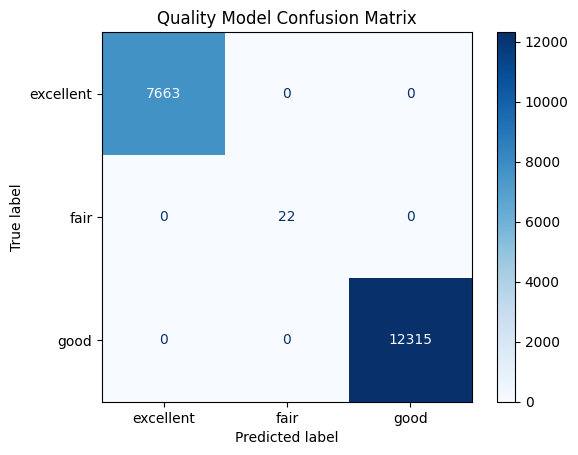


--- Tuning Naming Model ---
Best Score: 1.000

--- Evaluating Naming Model ---
              precision    recall  f1-score   support

        fair       1.00      1.00      1.00       447
        good       1.00      1.00      1.00     19553

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



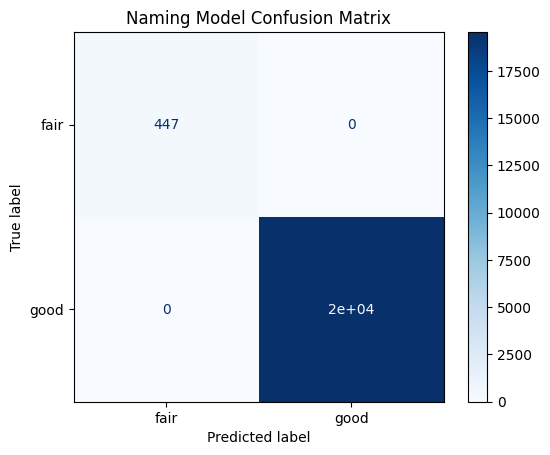


--- Tuning Style Model ---
Best Score: 0.998

--- Evaluating Style Model ---
              precision    recall  f1-score   support

        fair       1.00      1.00      1.00        93
        good       1.00      1.00      1.00     19907

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



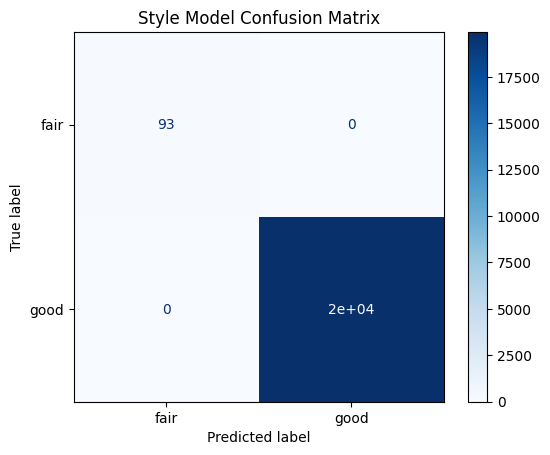


=== Training Complete ===


In [26]:
if train_data:
    critic.train_models(train_data)
else:
    print("Skipping training because no data was loaded. Check file paths and names.")

### Cell 6: Save the Final Model
After training, we save the entire critic object for later use.

In [27]:
if critic.is_trained:
    critic.save(MODEL_PATH)
else:
    print("Model not trained. Skipping save.")

Model saved to /kaggle/working/optimized_py150_model.pkl


### Cell 7: Inference on Evaluation Data
Finally, we load the saved model and use it to critique a few samples from the evaluation set. This demonstrates how the model would be used in a real-world scenario.

In [ ]:
if os.path.exists(MODEL_PATH):
    print(f"Loading model from {MODEL_PATH}...")
    inference_critic = MLCodeCriticAST.load(MODEL_PATH)
    
    eval_filepath = os.path.join(DATA_DIR, EVAL_FILENAME)
    if os.path.exists(eval_filepath):
        print("\n=== Critiquing 5 samples from the evaluation set: ===")
        with open(eval_filepath, "r") as f:
            for i, line in enumerate(f):
                if i >= 50000: break
                try:
                    ast_json = json.loads(line)
                    result = inference_critic.predict(ast_json)
                    print(f"\n--- Sample {i+1} ---")
                    print(f"  Quality: {result['quality']}")
                    print(f"  Naming:  {result['naming']}")
                    print(f"  Style:   {result['style']}")
                    print("  Suggestions:")
                    for suggestion in result['suggestions']:
                        print(f"    - {suggestion}")
                except json.JSONDecodeError:
                    continue
    else:
        print(f"Evaluation file not found at {eval_filepath}. Cannot run inference.")
else:
    print("Saved model not found. Please run the training and saving cells first.")

Loading model from /kaggle/working/optimized_py150_model.pkl...

=== Critiquing 5 samples from the evaluation set: ===

--- Sample 1 ---
  Quality: excellent
  Naming:  good
  Style:   good
  Suggestions:
    - ✅ Great work! Code looks clean and follows good practices.

--- Sample 2 ---
  Quality: excellent
  Naming:  good
  Style:   good
  Suggestions:
    - ✅ Great work! Code looks clean and follows good practices.

--- Sample 3 ---
  Quality: good
  Naming:  good
  Style:   good
  Suggestions:
    - ✅ Great work! Code looks clean and follows good practices.

--- Sample 4 ---
  Quality: excellent
  Naming:  good
  Style:   good
  Suggestions:
    - ✅ Great work! Code looks clean and follows good practices.

--- Sample 5 ---
  Quality: excellent
  Naming:  good
  Style:   good
  Suggestions:
    - ✅ Great work! Code looks clean and follows good practices.

--- Sample 6 ---
  Quality: excellent
  Naming:  good
  Style:   good
  Suggestions:
    - ✅ Great work! Code looks clean and foll